In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Магия для того, чтобы notebook автоматически подгружал изменения кода в файлах на диске
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import tqdm
VIDTIMIT_PATH = '../data/vidtimit/'

from nn.speaker import Dataset
from torchvision import transforms
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(0.5,0.5,0.5,0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
    ])

train_set = Dataset(VIDTIMIT_PATH, transform, exclude=['fadg0'])
print("Loaded classes:", train_set.c)

valid_set = Dataset(VIDTIMIT_PATH, transform, include=['fadg0'])
print("Loaded classes:", valid_set.c)
img = valid_set[0][0]

#dl = torch.utils.data.DataLoader(dataset=train_set, batch_size=8, shuffle=False)
# for i, (images, labels) in enumerate(mn_dataset_loader):
#     if i == 5: break
#     # Feed the data to the model
#     print(images[0].shape, labels[0])

100810it [00:00, 287929.01it/s]
2732it [00:00, 274436.90it/s]

Loaded classes: {0: 64787, 1: 36023}
Loaded classes: {0: 1694, 1: 1038}


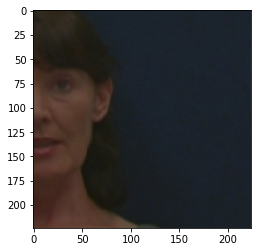

In [3]:
plt.imshow(img.permute(1,2,0))

In [4]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import Module
import torch.nn
from nn.speaker import get_speaking_detector, Net

#model = torch.nn.DataParallel(model).cuda()
from nn.trainer import Trainer
class MyTrainer(Trainer):
    def save(self, epoch):
        self.net.__class__ = Net
        torch.save(self.net, '../data/speaker/model.e{}.pt'.format(epoch))
        
    def get_options(self, epoch):
        loss = CrossEntropyLoss()
        trainable = filter(lambda p: p.requires_grad, self.net.parameters())
        if epoch<12:
            opt = Adam(trainable, lr=0.005, weight_decay=5e-4)
        elif epoch<18:
            opt = Adam(trainable, lr=0.001, weight_decay=2e-4)
        elif epoch<24:
            opt = Adam(trainable, lr=0.00031, weight_decay=5e-5)
        return loss, opt
    
    def get_data(self):
        dl = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True, num_workers=4)
        for i, (images, labels) in enumerate(dl):
            #print(len(images), images[0].shape, len(labels), labels)
            yield (images.cuda(), labels.cuda())

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [5]:
import random
start = 0
if start > 0:
    net = get_speaking_detector(start-1)
else:
    net = Net()
    net.cuda();
t = MyTrainer(net, N_seconds=10, seed=random.randrange(1<<31), start=start)
t.train_net(2, 500)

[0,     1] loss: 0.931
[0,    41] loss: 0.784
[0,    82] loss: 0.661
[0,   122] loss: 0.483
[0,   165] loss: 0.455
[0,   207] loss: 0.431
[0,   249] loss: 0.400
[0,   289] loss: 0.369
[0,   331] loss: 0.391
[0,   373] loss: 0.394
[0,   411] loss: 0.368
[0,   449] loss: 0.372
[0,   490] loss: 0.391
[0,   500] loss: 0.382
[1,     1] loss: 0.439
[1,    40] loss: 0.380
[1,    77] loss: 0.381
[1,   121] loss: 0.363
[1,   163] loss: 0.355
[1,   205] loss: 0.348
[1,   249] loss: 0.337
[1,   293] loss: 0.358
[1,   337] loss: 0.342
[1,   381] loss: 0.364
[1,   421] loss: 0.355
[1,   461] loss: 0.374
[1,   500] loss: 0.336


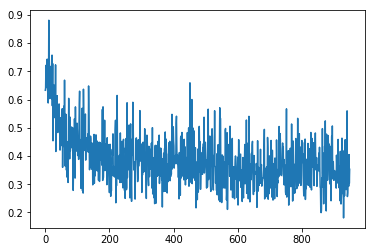

In [6]:
losses = t.get_losses()
plt.plot(losses[50:]); # random guessing loss is 0.69
#plt.yscale('log');
plt.show();